In [1]:
import torch
import numpy as np
import sys
import os

sys.path.append(os.getcwd()+'/../src/')
%load_ext autoreload
%autoreload 2

from attribute import *
from plot import *
from ppo_policy import *
from utils import *

/Users/amalota/anaconda3/envs/py37_trainloop/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sb3_contrib import RecurrentPPO

In [3]:
BASE_PATH = '../../output_models_initial'
BASE_PATH2 = '../../initial_model'

In [5]:
# model = RecurrentPPO.load(f'{BASE_PATH}/recurrentppo/CnnLstmPolicy/best_model.zip')
model = RecurrentPPO.load(f'{BASE_PATH2}/best_models/recurrentppo_CnnLstmPolicy')
# model = RecurrentPPO.load('../output_models/recurrentppo/MlpLstmPolicy/2022-06-14_22_27_08_9.zip')


X = np.load(f'{BASE_PATH2}/observations/observations_recurrentppo_CnnLstmPolicy_15.npy')
# X = np.load(f'{BASE_PATH2}/recurrentppo/CnnLstmPolicy/observations.npy')
X = torch.Tensor(X)
X.shape

torch.Size([6891, 1, 1, 15, 7])

In [ ]:
predictions = []
for _ in X:
    predictions.append(model.predict(X[0])[0][0])
predictions = np.array(predictions)

In [7]:
# predictions = np.squeeze(np.load(f'{BASE_PATH2}/recurrentppo/CnnLstmPolicy/actions.npy'), axis=1)
predictions = np.squeeze(np.load(f'{BASE_PATH2}/actions/actions_recurrentppo_CnnLstmPolicy.npy'), axis=1)

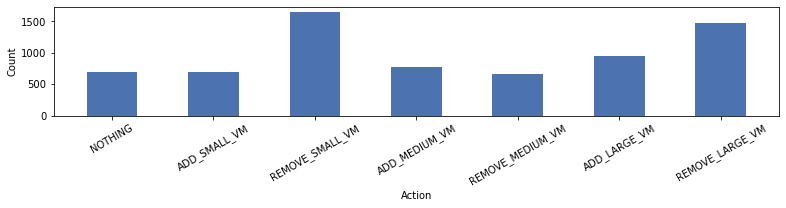

In [8]:
plot_action_histogram(predictions)

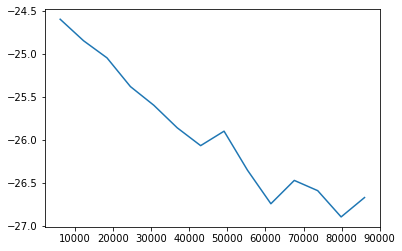

In [10]:
df = parse_tensorboard(path=f'{BASE_PATH}/recurrentppo/CnnLstmPolicy/RecurrentPPO_6', scalars=['rollout/ep_rew_mean'])
plt.plot(df['rollout/ep_rew_mean']['step'], df['rollout/ep_rew_mean']['value'])

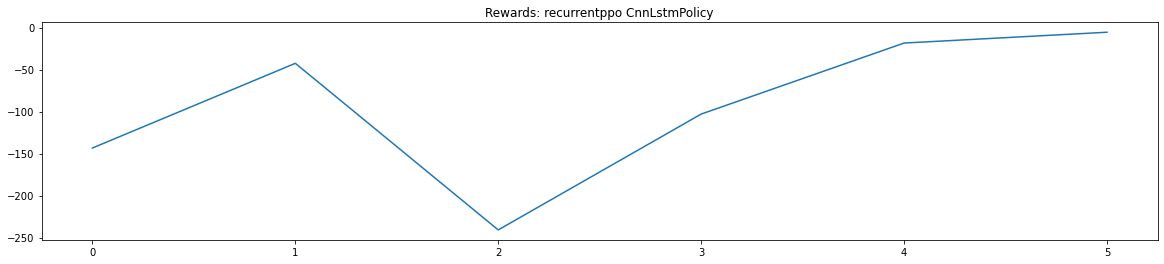

In [142]:
plot_training_data(f'{BASE_PATH}/recurrentppo/CnnLstmPolicy/training_data.csv', data_type='reward', title='recurrentppo CnnLstmPolicy')

# Attributions

In [9]:
from ppo_policy import RecurrentPPOCnnPolicy, RNNStates
ppo_net = RecurrentPPOCnnPolicy(model.observation_space, model.action_space, model.lr_schedule, model)

In [10]:
ppo_net.lstm_hidden_state_shape

(1, 1, 256)

In [11]:
x = torch.tensor(X[0])
# x = torch.tensor(X)
ppo_net.forward(
            x, 
            lstm_states=RNNStates(
                pi=(torch.zeros(ppo_net.lstm_hidden_state_shape), torch.zeros(ppo_net.lstm_hidden_state_shape)), 
                vf=(torch.zeros(ppo_net.lstm_hidden_state_shape), torch.zeros(ppo_net.lstm_hidden_state_shape))),
            episode_starts=torch.zeros(0))

/Users/amalota/anaconda3/envs/py37_trainloop/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


tensor([-1.8728], grad_fn=<SqueezeBackward1>)

In [12]:
x = torch.tensor(X[1])
ppo_net.predict(x)[0][0]

/Users/amalota/anaconda3/envs/py37_trainloop/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


5

In [13]:
# Random samples
N = 1000
idxs = np.random.choice(np.arange(X.shape[0]), size=N)
X_sample = X[idxs]
predictions_sample = predictions[idxs]

# Sequential samples
# i_start = 0
# i_stop = 500
# X_sample = X[i_start:i_stop]
# predictions_sample = predictions[i_start:i_stop]

ig_attributor = IGAttributor(net=ppo_net,
                            policy='cnn',
                            agent='ppo',
                            data=X_sample,
                            predictions=predictions_sample,
                            forward_args=(RNNStates(
                    pi=(torch.zeros(1, 1, 256), torch.zeros(1, 1, 256)), 
                    vf=(torch.zeros(1, 1, 256), torch.zeros(1, 1, 256))),
                    torch.zeros(0)))

# Mean Attributions

In [14]:

mean_attributions_per_action = ig_attributor.get_mean_attributions()

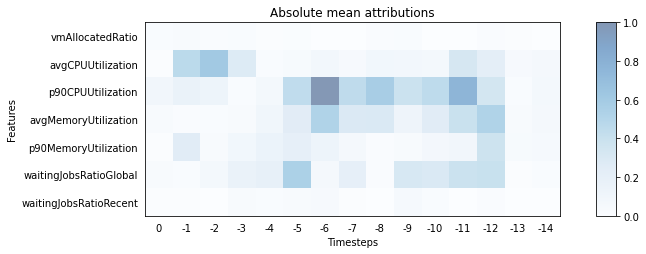

In [15]:
plot_mean_attributions(mean_attributions=mean_attributions_per_action[0], policy='cnn', abs=True)

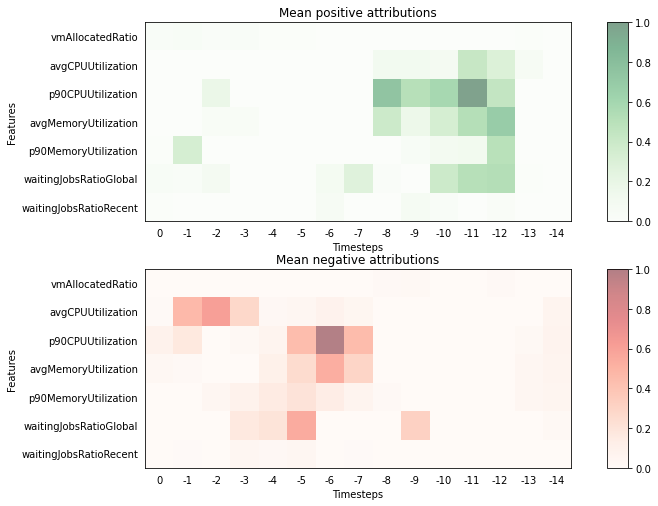

In [16]:
plot_mean_attributions(mean_attributions=mean_attributions_per_action[0], policy='cnn')

# Attributions for examples

Action made: ADD_LARGE_VM


/Users/amalota/Documents/trainloop-driver/analysis/initial_training/../src/viz.py:47: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  "Attempting to normalize by value approximately 0, visualized results"


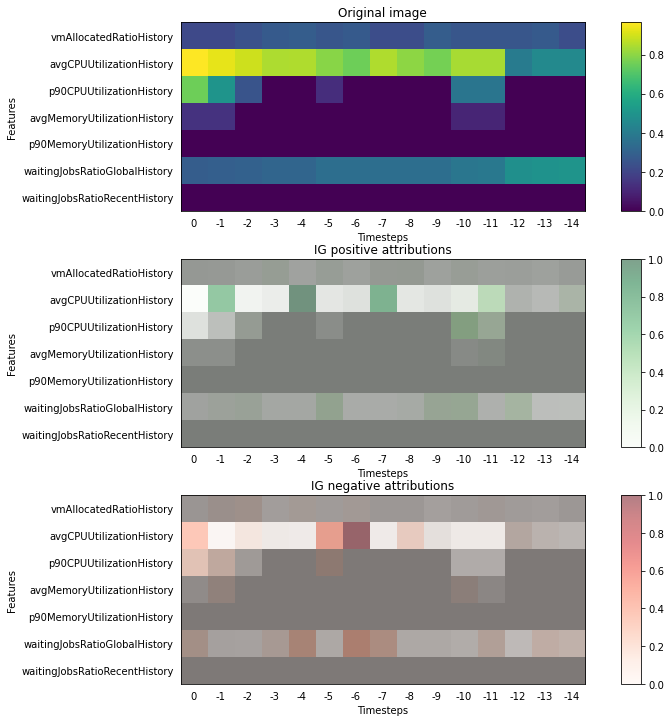

In [78]:
ig_attributor.explain_example(115)

Action made: ADD_MEDIUM_VM


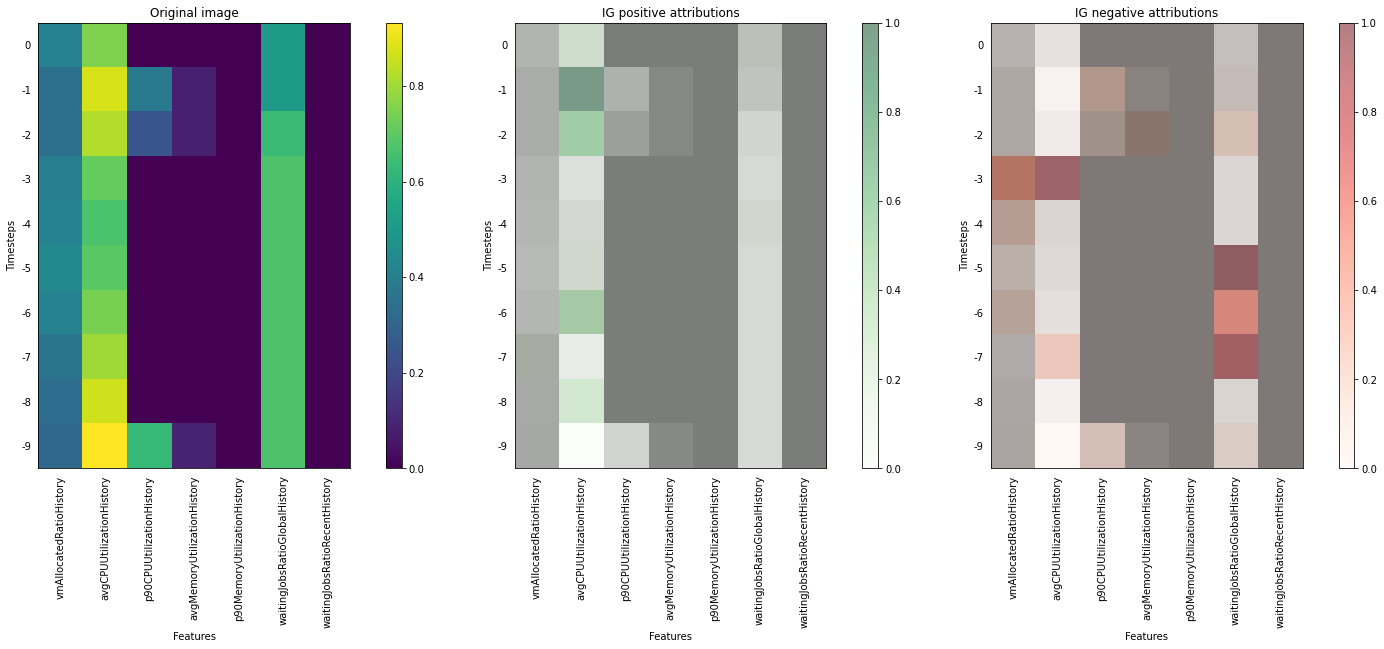

In [32]:
ig_attributor.explain_example(115)

Action made: NOTHING


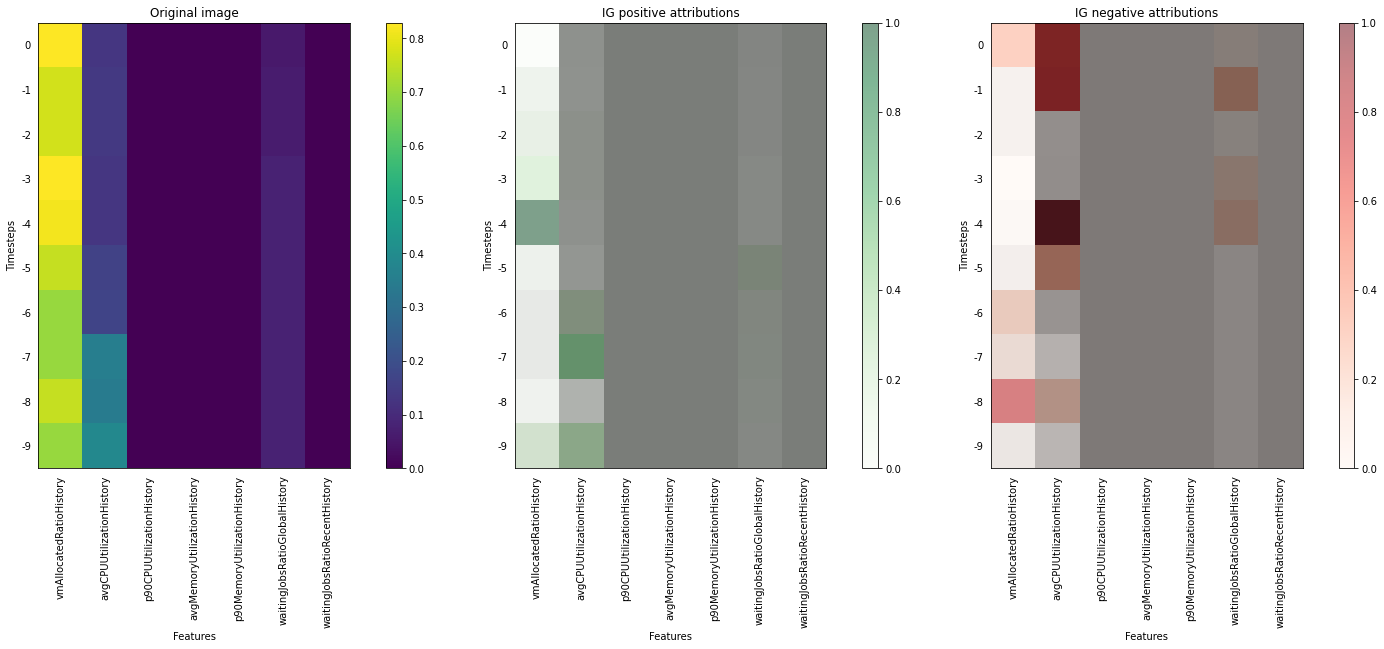

In [34]:
ig_attributor.explain_example(215)

In [35]:
action_observation_map = get_action_observation_map(predictions)

Observation count for each action:
{'ADD_LARGE_VM': 545,
 'ADD_MEDIUM_VM': 537,
 'ADD_SMALL_VM': 526,
 'NOTHING': 503,
 'REMOVE_LARGE_VM': 506,
 'REMOVE_MEDIUM_VM': 524,
 'REMOVE_SMALL_VM': 540}


In [105]:
idx = action_observation_map['REMOVE_LARGE_VM'].squeeze(1)[:500]

In [106]:
ig_attributor = IGAttributor(net=ppo_net,
                            policy='cnn',
                            agent='ppo',
                            data=X[idx],
                            predictions=predictions[idx],
                            forward_args=(RNNStates(
                    pi=(torch.zeros(1, 1, 256), torch.zeros(1, 1, 256)), 
                    vf=(torch.zeros(1, 1, 256), torch.zeros(1, 1, 256))),
                    torch.zeros(0)))

Action made: REMOVE_LARGE_VM


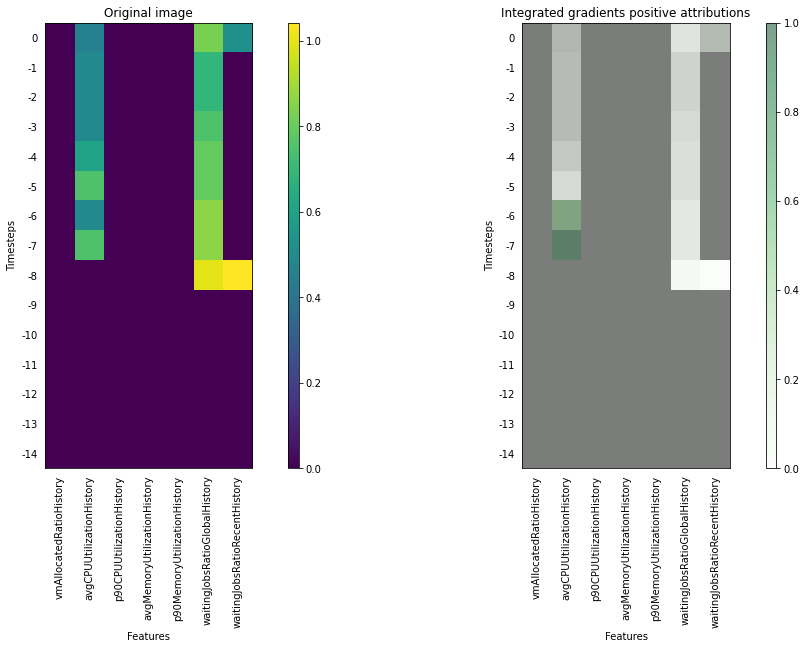

In [107]:
ig_attributor.explain_example(idx=0)

In [132]:
X_manual = torch.Tensor([[[
    [[0, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 1, 1]],
    # [[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]],
    # [[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]]
    ]]])

predictions_manual = []
for _ in X_manual:
    predictions_manual.append(model.predict(X_manual[0])[0][0])
predictions_manual = np.array(predictions_manual)

In [133]:
ig_attributor = IGAttributor(net=ppo_net,
                            policy='cnn',
                            agent='ppo',
                            data=X_manual,
                            predictions=predictions_manual,
                            forward_args=(RNNStates(
                    pi=(torch.zeros(1, 1, 256), torch.zeros(1, 1, 256)), 
                    vf=(torch.zeros(1, 1, 256), torch.zeros(1, 1, 256))),
                    torch.zeros(0)))

Action made: ADD_LARGE_VM


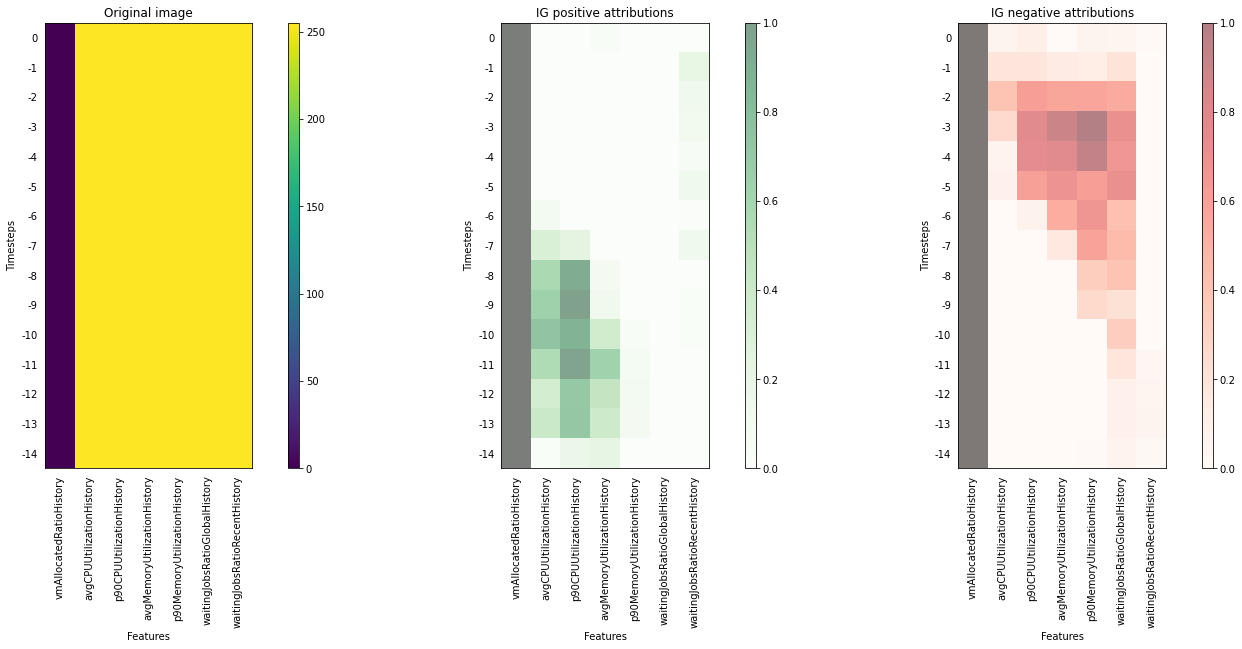

In [134]:
ig_attributor.explain_example(idx=0)

In [135]:
X.shape

torch.Size([5769, 1, 1, 15, 7])

In [ ]:
np.argwhere(X == i)